In [ ]:
import re
from collections import Counter

import numpy as np
import pandas as pd
import squarify
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import nltk
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.duplicated().sum(), df.isna().sum().sum()

In [ ]:
df = df.drop_duplicates()

In [ ]:
# 10000개 데이터만 사용

df = df.sample(10000, random_state=42).reset_index(drop=True)

In [ ]:
# df['target'] = df['sentiment'].replace({'positive': 1, 'negative': 0})

label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
df.head()

# 1. Preprocessing

## a. Regular Expression

In [ ]:
# lower case로 변환, 특수 문자 제거
def lower_clean(sentence):
    sentence = sentence.lower() # 소문자로 변환
    sentence = re.sub(r"[^a-z0-9 ]", "", sentence) # 정규식 외 표현은 모두 빈칸으로
    return sentence

df['token'] = df['review'].map(lower_clean).str.split() # 토큰화

In [ ]:
df['token'].head()

In [ ]:
word_counter = Counter()
df['token'].map(lambda x: word_counter.update(x))

print("Total number of word:", len(word_counter))

In [ ]:
temp = pd.Series(word_counter.values())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(temp, bins=100)
axes[0].set_title("Word Counts")
axes[1].hist(temp, bins=100, range=[0, temp.quantile(q=0.99)])
axes[1].set_title("Word Counts under q=0.99")

plt.show()

많은 수의 단어가 빈도수가 매우 낮은 반면에 매우 많이 등장한 단어들도 있다. 이 단어들을 어떻게 처리해야하는가?

- 불용어 제거
- 어간 추출 (Stemming)
- 표제어 추출 (Lemmatization)
- 통계 기반 트리밍

## b. NLTK

In [ ]:
nltk.download('omw-1.4')

In [ ]:
def preprocessing(sentence):
    """
    lowecase, tokenize, drop stop words
    lemmatization and stemming
    """
    sentence = sentence.lower()
    sentence = re.sub(r"<br />", "", sentence)
    sentence = re.sub(r"[^a-z0-9 ]", "", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    
    tokenized = nltk.tokenize.word_tokenize(sentence)
    
    # remove stop words
    stop_words = nltk.corpus.stopwords.words('english')
    tokenized = [word for word in tokenized if word not in stop_words]
    
    # lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in tokenized]
    
    # stemming
    stemmer = nltk.stem.PorterStemmer()
    stems = [stemmer.stem(word) for word in tokenized]
    
    return sentence, tokenized, lemmas, stems

In [ ]:
sentences, tokenized, lemmas, stems = [], [], [], []
for i in tqdm(range(len(df))):
    sentence_, tokenized_, lemma_, stem_ = preprocessing(df['review'].iloc[i])
    sentences.append(sentence_)
    tokenized.append(tokenized_)
    lemmas.append(lemma_)
    stems.append(stem_)

In [ ]:
df['review'] = sentences
df['token_wo_stop'] = tokenized
df['lemma'] = lemmas
df['stem'] = stems

In [ ]:
token_counter = Counter()
lemma_counter = Counter()
stem_counter = Counter()

df['token_wo_stop'].map(lambda x: token_counter.update(x))
df['lemma'].map(lambda x: lemma_counter.update(x))
df['stem'].map(lambda x: stem_counter.update(x));

In [ ]:
list(map(len, [word_counter, token_counter, lemma_counter, stem_counter]))

In [ ]:
word_common = {k: v for k, v in word_counter.most_common(10)}
token_common = {k: v for k, v in token_counter.most_common(10)}
lemma_common = {k: v for k, v in lemma_counter.most_common(10)}
stem_common = {k: v for k, v in stem_counter.most_common(10)}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, common in enumerate([word_common, token_common, lemma_common, stem_common]):
    squarify.plot(sizes=common.values(), label=common.keys(), 
                  ax=axes[i//2, i%2], alpha=0.5, text_kwargs={'fontsize': 12})
    axes[i//2, i%2].axis('off')
axes[0, 0].set_title("All Words", fontsize=16)
axes[0, 1].set_title("without stop words", fontsize=16)
axes[1, 0].set_title("Lemmas", fontsize=16)
axes[1, 1].set_title("Stems", fontsize=16)
plt.suptitle("Most Frequent Words in IMDB Reviews", fontsize=18)
plt.tight_layout()
plt.show()

전체 단어를 대상으로 빈도를 계산 했을 때는 the나 and 같은 불필요한 단어들이 많이 나타났다.
불용어를 제거했을 때는 비교적 영화에 관련된 단어가 더 자주 등장했고, 표제어 추출이나 어간 추출을 했을 때는 등장하는 단어의 수가 1만 개 가량 줄었다. 하지만 어간 추출의 경우 단어를 그대로 잘라버리기 때문에 단어의 의미를 바로 알아차리기 어려운 경우도 있다 (ex. movi)

# 2. Word Representation

모델에 입력하려면 문자를 숫자로 바꿔주어야한다. 글자 그대로 알아들으면 얼마나 좋을까

## a. Count base Representation

### i. CounterVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english', 
                                   max_features=1000)
count_vectorized = count_vectorizer.fit_transform(df['review'])

count_vectorized = pd.DataFrame(count_vectorized.todense(), 
                                columns=count_vectorizer.get_feature_names_out())

count_vectorized.head()

In [ ]:
common_word_in_rows = []
for i, row in tqdm(count_vectorized.iterrows(), total=10000):
    word_counts = {k: v for k, v in row.sort_values(ascending=False)[:6].items()}
    common_word_in_rows.append(word_counts)

In [ ]:
for i in range(5):
    print("Text:\n", df['review'].iloc[i][:200]+'...', '\nWords:\n', common_word_in_rows[i], '\nLabel:', df['sentiment'].iloc[i], '\n')

CountVectorizer를 이용할 때 현재 데이터 중 가장 많이 나타난 1000개의 단어들만 사용했다.
각 문장에 vectorizer에 들어있는 단어가 몇 개인지 표시해준다.
하지만 이 경우에는 빈도만 나타낼 뿐 단어들의 순서에 대한 정보나 텍스트에서 어떤 단어가 중요한지 알아내기 어렵다. 이를 보완하기 위해 TfidfVectorizer를 사용한다.

### ii.TfidfVectorizer

Tfidf는 TF(Term Frequency) 와 IDF(Inverse Document Frequency)의 곱으로,


$TF$ = 특정 문서에서 해당 단어가 나타난 횟수

$IDF = \log{\frac{(모든\, 문서\, 수)}{1 + (해당\, 단어가\, 포함된\, 문서\, 수)}}$

으로 표현할 수 있다.
분모의 1은 0이 되는 것을 방지하기 위해 넣어준다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   max_features=1000)
tfidf_vectorized = tfidf_vectorizer.fit_transform(df['review'])

tfidf_vectorized = pd.DataFrame(tfidf_vectorized.todense(), 
                                columns=tfidf_vectorizer.get_feature_names_out())

tfidf_vectorized.head()

In [ ]:
common_word_in_rows = []
for i, row in tqdm(tfidf_vectorized.iterrows(), total=10000):
    word_counts = {k: v for k, v in row.sort_values(ascending=False)[:6].items()}
    common_word_in_rows.append(word_counts)

In [ ]:
for i in range(5):
    print("Text:\n", df['review'].iloc[i][:200]+'...', '\nWords:\n', common_word_in_rows[i], '\nLabel:', df['sentiment'].iloc[i], '\n')

리뷰가 긍정이냐 부정이냐에 따라 나타나는 단어의 빈도나 tfidf를 이용해서 중요한 단어들이 어떤건지 확인을 했다.
다섯 개의 샘플만 사용했기 때문에 전체적인 경향은 보기 어렵지만, 긍정이냐 부정이냐에 따라 나타나는 단어가 몇몇 있음을 알 수 있다. CounterVectorizer가 더 잘 나타났는데, 이는 'good' 같은 단어의 경우처럼 전체적으로 많이 나타나 TfidfVectorizer에서는 낮은 점수를 부여했을 가능성도 있다.

#### Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier

def evaluate_vectorizer(vectorized):
    X_train, X_test, y_train, y_test = train_test_split(vectorized, df['target'],
                                                        test_size=0.2, random_state=42)

    lgb_clf = LGBMClassifier()
    lgb_clf.fit(X_train, y_train)

    y_pred = lgb_clf.predict(X_test)
    print(classification_report(y_test, y_pred))


In [ ]:
evaluate_vectorizer(count_vectorized)

In [ ]:
evaluate_vectorizer(tfidf_vectorized)

#### Similarity

In [ ]:
from sklearn.neighbors import NearestNeighbors

def nearest_review(vectorized, idx):
    nn = NearestNeighbors(n_neighbors=20)
    nn.fit(vectorized.to_numpy())
    near_idx = nn.kneighbors([vectorized.iloc[idx]])[1][0]
    
    for i in near_idx[:5]:
        if i == idx:
            print(f"Ref review: \n{df['review'].iloc[i][:200]}...")
            print("Ref Label:", df['sentiment'].iloc[i])
        else:
            print('='*50)
            print(f"Review: \n{df['review'].iloc[i][:200]}...")
            print("Label:", df['sentiment'].iloc[i])
    return near_idx

In [ ]:
count_vectorized_near = nearest_review(count_vectorized, 1)

In [ ]:
tfidf_vectorized_near = nearest_review(tfidf_vectorized, 1)

knn을 사용해 특정 리뷰와 유사도를 측정해도 CountVectorizer와 TfidfVectorizer 간에는 큰 차이가 없어보인다.
두 방법 모두 문맥이 아닌 단어의 빈도만으로 단어에 값들을 부여하고 모든 단어를 사용하기 때문에 차원이 매우 커지는 경우가 생기게 된다. 이를 방지하기 위해 단어 수를 제한하면 특정 문서나 중요한 단어를 전혀 활용할 수 없게 될 수도 있다.

## b. Distributed Representation
[Distributional Semantics](https://en.wikipedia.org/wiki/Distributional_semantics)

위처럼 고차원 벡터를 사용할 때 나타날 수 있는 문제를 해결하기 위해 입력을 저차원의 임베딩 공간의 벡터로 만들어준다. 

### i. Word2Vec
[paper](https://arxiv.org/pdf/1301.3781.pdf)  

단어를 벡터로 만들기 위해 중심단어와 주변 단어들을 사용한다.

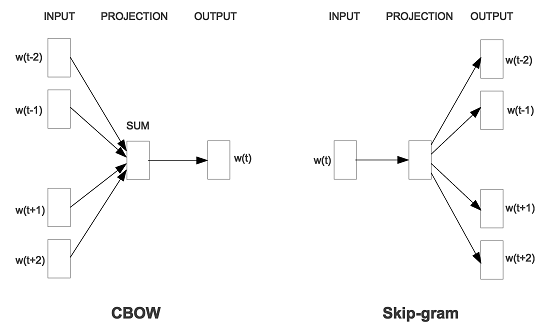
- CBoW  
주변 단어를 기반으로 중심 단어 예측

- Skip-gram  
중심 단어를 기반으로 주변 단어 예측

In [ ]:
from gensim.models import Word2Vec

w2v = Word2Vec(vector_size=100,
               window=5,
               negative=10,
               sg=1) # 1 for skip gram


w2v.build_vocab(df['token_wo_stop'])

In [ ]:
w2v.wv.save("trained_from_imdb_review")

In [ ]:
w2v.wv.most_similar(positive=['good'])

In [ ]:
w2v.wv.most_similar(positive=['bad'])

# 3. Keras Embedding Layer
[Keras Embedding Layer](https://keras.io/api/layers/core_layers/embedding/)
- embedding layer
- pretrained embedding matrix (gensim Word2Vec, GloVe)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['target'],
                                                    test_size=0.2, random_state=42)

In [ ]:
num_words = 3000

tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [ ]:
length_list = list(map(len, X_train_tk))

plt.figure(figsize=(8, 5))
plt.hist(length_list, bins=50)
plt.axvline(np.mean(length_list), linewidth=3, c='k')
plt.text(x=np.mean(length_list)+50, y=1600, s=int(np.mean(length_list)))
plt.title("Sequence Length Distribution")
plt.show()

In [ ]:
maxlen = 300

X_train_pad = pad_sequences(X_train_tk, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_tk, maxlen=maxlen)

In [ ]:
X_train_pad.shape, X_test_pad.shape

In [ ]:
def get_model():
    inputs_ = tf.keras.Input(shape=maxlen)
    embedding = tf.keras.layers.Embedding(num_words, 128, input_length=maxlen)(inputs_)
    average_pool = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    outputs_ = tf.keras.layers.Dense(1, activation='sigmoid')(average_pool)
    
    model = tf.keras.Model(inputs=[inputs_], outputs=[outputs_])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics='accuracy')
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('review_classify.hdf5',
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    mode='max',
                                                    patience=5)

model.fit(X_train_pad, y_train,
          batch_size=128,
          epochs=50,
          validation_split=0.2,
          callbacks=[checkpoint_cb, earlystopping_cb])

In [ ]:
# 위에서 학습한 w2v를 이용한다면
word_vec = w2v.wv.load("trained_from_imdb_review")

In [ ]:
def get_vector(word):
    if word in word_vec:
        return word_vec[word]
    else:
        return None
    
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    vector = get_vector(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [ ]:
def get_model():
    inputs_ = tf.keras.Input(shape=maxlen)
    embedding = tf.keras.layers.Embedding(vocab_size, 100, input_length=maxlen,
                                          weights=[embedding_matrix])(inputs_)
    average_pool = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    outputs_ = tf.keras.layers.Dense(1, activation='sigmoid')(average_pool)
    
    model = tf.keras.Model(inputs=[inputs_], outputs=[outputs_])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics='accuracy')
    
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

학습한 데이터가 적기때문에 성능은 좋지 않다.

# 3. Model


## a. RNN & LSTM
[cs224n 참고](https://youtu.be/0LixFSa7yts)

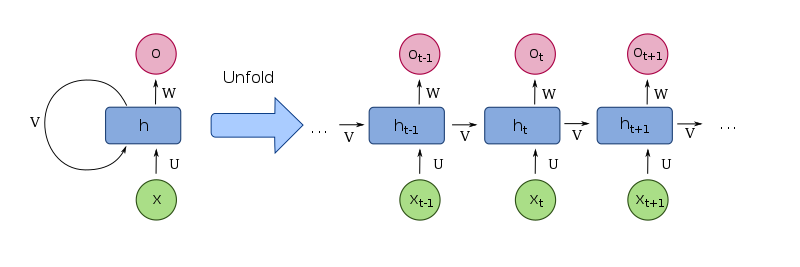

RNN은 이전 시점에서의 hidden state를 현재 시점에 다시 입력해줘서 이전의 값들을 기억하도록 해준다. 식으로 표현하면  
$h^{(t)} = tanh(W_hh^{(t-1)} + W_xx^{(t)} + b) $  

$h^{(t)}$ 는 이전 시점의 입력($x^{(t-1)}$)까지 정보를 모두 가지고 있다. 모든 시점에서 $W$는 같은 값을 가진다.

이론적으로는 무한대 길이의 입력을 기억할 수 있지만, 길이가 길어질수록 역전파 과정에서 그레디언트가 소실되므로 과거 데이터의 의미가 사라진다.
tanh의 미분하면 $1-tanh^2\,x$로 0 부터 1 사이의 값을 가지지만 $x=0$ 주변을 제외하면 거의 0에 가깝다.

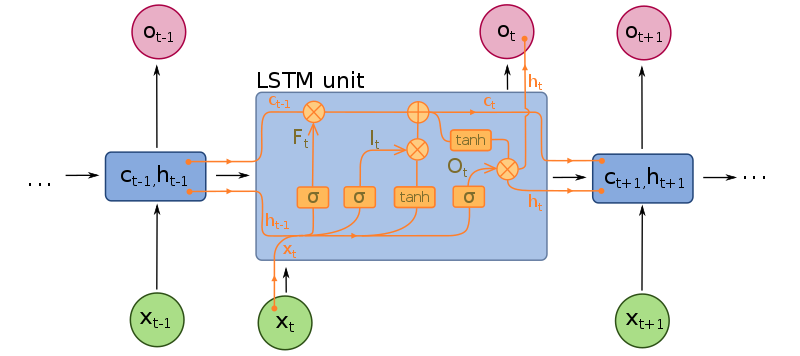

RNN의 위와 같은 문제를 해결하기 위해 3개의 게이트를 이용한 LSTM을 사용한다.
위 그림에서 $F_t$가 있는 게이트가 Forget Gate, $I_t$가 있는 게이트가 Input Gate, $O_t$가 있는 게이트가 Output Gate이다.

- Gate  
$f^{(t)} = \sigma(W_fh^{(t-1)} + U_fx^{(t)} + b_f)$ - Forget Gate  
$i^{(t)} = \sigma(W_ih^{(t-1)} + U_ix^{(t)} + b_i)$ - Input Gate  
$o^{(t)} = \sigma(W_oh^{(t-1)} + U_ox^{(t)} + b_o)$ - Output Gate  

Gate에서는 시그모이드 함수를 통과해 입력을 얼마나 활용할지 결정한다.  
Forget Gate는 이전 셀 상태를,  
Input Gate는 새로운 셀 정보를,  
Output Gate는 셀이 다음 은닉 상태로 보낼지  
0부터 1 사이 값으로 알려준다.

- State
    - Cell State  
        $\tilde{c}^{(t)} = \tanh(W_ch^{(t-1)} + U_cx^{(t)} + b_c)$  
        $c^{(t)} = f^{(t)} \circ c^{(t-1)} + i^{(t)} \circ \tilde{c}^{(t)}$  
    - Hidden State  
        $h^{(t)} = o^{(t)} \circ \tanh c^{(t)}$
        
새로운 셀 값을 위한 $\tilde{c}^{(t)}$는 입력게이트 부분에서 $\tanh$를 거쳐 다음 셀 상태를 계산하는데 사용된다. 기존의 RNN 구조와 동일하다고 볼 수 있다.  

다음 셀 상태는 $\tilde{c}^{(t)}$와 입력 게이트의 $i^{(t)}$의 아다마르 곱($\circ$, Element wise product)과, Forget Gate를 통과해 이전 데이터가 어느정도 삭제된 값이 더해져서 결정된다.

다음 은닉 상태는 출력게이트($o^{(t)}$)와, $\tanh$를 통과한 셀 상태의 아다마르 곱으로 결정된다.
    
셀 상태를 보면 활성화 함수를 통과하지 않고 비율이 곱해지고 더해지는 것 뿐이어서 RNN에서 제기되었던 장기기억 문제가 어느정도 해소된다.

keras로 쓸땐 그냥 
```python
tf.keras.layers.LSTM(output_dim, 뒤에 파라미터들) 
```
쓰면 된다.  
`return_sequence = True`: 모든 시점의 은닉상태를 출력해준다.  
`return_state = True`: 마지막 시점의 은닉 상태와 셀 상태를 출력해준다.  
둘 다 True로 한다면,  
모든_시점_은닉상태, 마지막_은닉상태, 마지막_셀상태 = lstm(x)  
처럼 출력해준다.
return_state만 True로 하면 모든 시점이 아니라 마지막 은닉상태가 나온다.

cudnn을 사용하기 위한 조건도 있는데 [keras lstm](https://keras.io/api/layers/recurrent_layers/lstm/)에 써져있다. 다 기본값이라 안건드리면 빠르게 실행된다.  


## b. Seq2Seq (encoder-decoder)

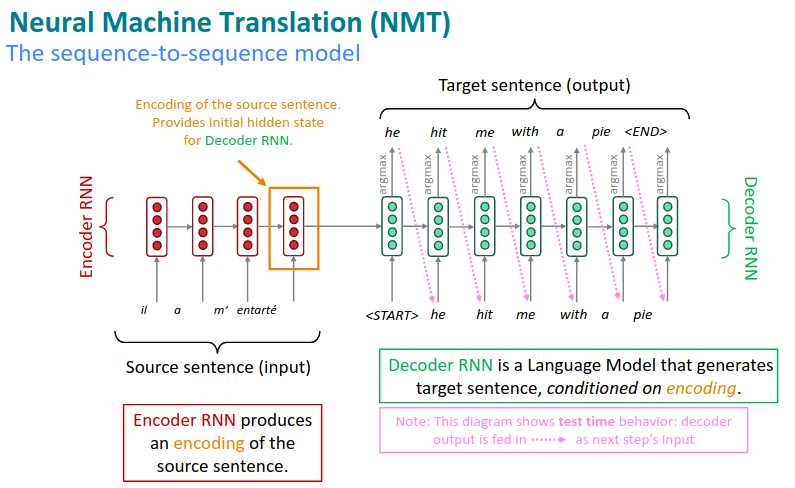

Source: [CS224N](http://web.stanford.edu/class/cs224n/)


기계번역에 사용되는 Sequence-to-Sequence 모델은 인코더와 디코더 두 부분으로 구성된다.  
인코더 내부의 순환 신경망에 시퀀스가 순차적으로 들어간다. 위 그림에서는 RNN이 사용되었지만 장기기억 문제 때문에 LSTM을 사용하는 것이 좋다. 인코더의 마지막 부분의 은닉 상태가 디코더의 초기 상태로 입력된다. 이 상태가 인코더에 있는 모든 정보를 모은 컨텍스트 벡터이다. 모델을 학습시킬 때에는 디코더에 시작 토큰 부터 입력되며 인코더에 입력되는 문장의 번역된 결과가 순차적으로 들어간다. 테스트시에는 각 시점의 디코더 출력이 다음 시점에 디코더 입력으로 들어간다. 마지막 종료 토큰이 예측값으로 나타날 때까지 이를 반복한다.  

먼저 위 Keras 예제처럼 문장을 전처리 한 후 토큰화시켜 같은 길이로 패딩을 추가하거나 잘라준다. 디코더로 입력되는 문장에는 시작 토큰과 종료 토큰을 추가해주어야 한다. 입력되는 단어들은 모두 임베딩 층을 통과한 후 입력된다.  

이 모델을 keras로 만들어보면

In [ ]:
# import
import tensorflow as tf
from tensorflow.keras import layers

# params
enc_maxlen = 30 # 번역하려는 언어의 문장 길이 
dec_maxlen = 30 # 번역된 언어의 문장 길이
enc_vocab_size = 3000 # 토크나이저로 구한 값이어야함, len(tokenizer.word_index)+1
dec_vocab_size = 3000 # ..
embedding_dim = 128
units = 128

In [ ]:
# Encoder
encoder_inputs = tf.keras.Input(shape=(enc_maxlen,))
encoder_embedding = layers.Embedding(enc_vocab_size, embedding_dim, input_length=enc_maxlen)
encoder_masking = layers.Masking(mask_value=0.)
# 인코더의 마지막 상태를 디코더로 넘겨줘야 하기 때문에 return_state=True 로 둔다
encoder_lstm = layers.LSTM(units, return_state=True)

encoder_x = encoder_embedding(encoder_inputs)
encoder_x = encoder_masking(encoder_x)
encoder_output, encoder_hidden, encoder_carry = encoder_lstm(encoder_x)

# Decoder
decoder_inputs = tf.keras.Input(shape=(dec_maxlen,)) 
decoder_embedding = layers.Embedding(dec_vocab_size, embedding_dim, input_length=dec_maxlen)
decoder_masking = layers.Masking(mask_value=0.)
# 매 시점마다 출력을 다음 시점에 입력으로 사용해야하기 때문에 return_sequence=True 로 둔다
decoder_lstm = layers.LSTM(units, return_state=True, return_sequences=True) 
# 매 시점마다 단어 예측을 위해 Dense 층 추가
decoder_dense = layers.Dense(dec_vocab_size, activation='softmax')

decoder_x = decoder_embedding(decoder_inputs)
decoder_x = decoder_masking(decoder_x)
# 하지만 훈련 과정에서는 디코더의 은닉 상태나 셀 상태를 사용하지 않는다.
decoder_outputs, _, _ = decoder_lstm(decoder_x,
                                     initial_state=[encoder_hidden, 
                                                    encoder_carry])
decoder_outputs = decoder_dense(decoder_outputs)

# 연결해서 모델 만들기
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[decoder_outputs])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

마지막 Dense 층의 shape을 보면 디코더의 3000개 단어에 대한 확률을 문장 길이 30개마다 출력하는 것을 확인할 수 있다.  
model.compile 하고 fit 하면 훈련과정이 완료된다.

훈련때 사용한 층들을 재사용 해 예측을 진행하면 된다.  
인코더는 디코더에 마지막 상태를 넘겨줘야하므로, 출력을 마지막 은닉 상태와 셀 상태로 모델을 구성한다.
디코더의 경우는 훈련시와 달리 이전 상태를 받으면서 종료 토큰이 나올때까지 반복해야하기 때문에 은닉 상태와 셀 상태를 넘겨주어야한다. 테스트를 할 때는 디코더로 시작 토큰만 넘겨주고 다음 단어를 예측하게 만든다.  
자세한 설명은 [여기](https://wikidocs.net/86900)

In [ ]:
# Encoder for Test 이전과 같음
encoder = tf.keras.Model(inputs=[encoder_inputs], 
                         outputs=[encoder_hidden, encoder_carry])

# Decoder for Test 은닉 상태와 셀 상태 추가
decoder_hidden_init = tf.keras.Input(shape=(units,))
decoder_carry_init = tf.keras.Input(shape=(units,))

decoder_test_x = decoder_embedding(decoder_inputs)
decoder_test_output, decoder_hidden, decoder_carry = decoder_lstm(decoder_test_x,
                                                                  initial_state=[decoder_hidden_init,
                                                                                 decoder_carry_init])
decoder_test_output = decoder_dense(decoder_test_output)
decoder = tf.keras.Model(inputs=[decoder_inputs, decoder_hidden_init, decoder_carry_init],
                         outputs=[decoder_test_output, decoder_hidden, decoder_carry])

In [ ]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

## c. Attention

하지만 위 seq2seq 모델에서 인코더의 마지막 출력에 정보가 압축되어있다보니 시점을 고려한 정확한 번역을 하기에는 어려움이 있다. 그래서 디코더의 예측이 인코더의 어떤 시점에 중점을 둬야하는지 알려주는 Attention 기법을 사용한다.

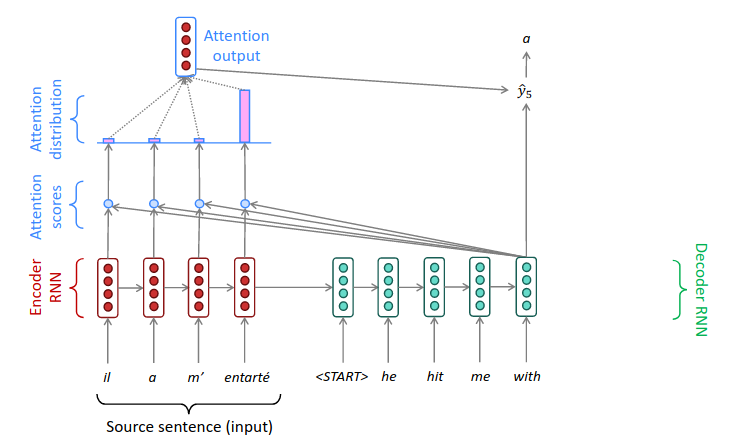

Source: [CS224N](http://web.stanford.edu/class/cs224n/)

Attention은 쿼리, 키, 키에 맵핑된 값으로 어텐션 값을 구한 후 이를 통해 인코더에서 어떤 단어에 집중할 지 알려준다.  
쿼리(Query, Q)는 디코더의 t 시점에서 출력,  
키(Key, K)와 값(Value, V)은 인코더의 모든 시점에서 출력이다.  
위 그림에서 디코더의 입력으로 with이 들어와 출력을 예측한다 하면, with이 입력되었을 때 출력(쿼리, Q)과 인코더의 모든 시점에서 출력(키, K)을 내적해 어텐션 스코어를 구해준다.  
$Attention\,scores = Encoder\,Hidden^{(all)} \cdot Decoder\, Hidden^{(t)}$  
이 어텐션 스코어들을 softmax 함수를 통과시켜 Attention distribution을 구하고 인코더의 출력(값, V)과 곱하고 더해준다. softmax를 통과한 후 더했기 때문에 디코더의 시점과 연관성이 높은 인코더의 출력이 Attention Output에 많이 포함된다. 이 출력 벡터와 t 시점(위 사진에서는 입력이 with 일 때)의 디코더 벡터를 병합시키고, Dense 층을 통과한 후, softmax 함수를 통과시켜 최종 출력을 내게 된다.

자세한 내용은 위 사진의 [강의](https://youtu.be/wzfWHP6SXxY)나 [위키독스](https://wikidocs.net/22893)에 설명이 있다. 바다나우 어텐션을 이용한 [코드](https://wikidocs.net/48920)도 있다.

## d. Transformer

아예 LSTM같은 순환 신경망 구조를 사용하지 않고 위의 어텐션만을 이용한 모델로 트랜스포머가 있다.
순환 신경망 구조는 순차적으로 데이터가 입력되기 때문에 속도가 느린 단점이 있다. 트랜스포머는 데이터가 병렬로 입력되서 더 빠르게 학습할 수 있다.

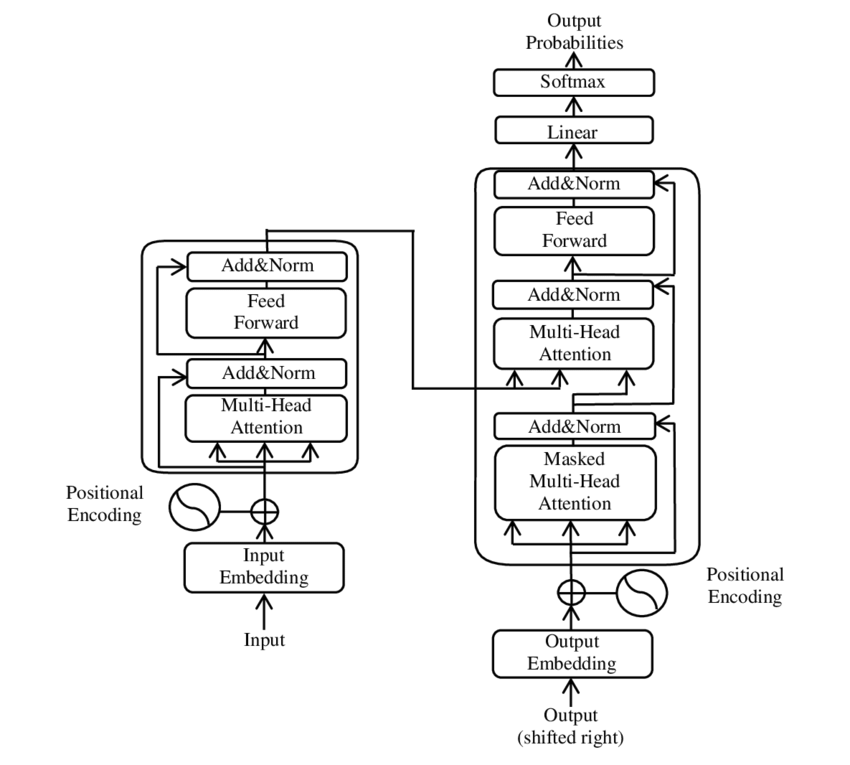

구조가 복잡해보이지만 하나씩 나눠서 입력부분부터 보면 좀 낫다.  

위 사진의 왼쪽이 인코더, 오른쪽이 디코더이다.  
먼저 인코더부터 보면 입력값들이 임베딩 층을 통과하고 Positional Encoding 이라는 것과 더해져 Multi-Head Attention으로 입력된다. 이 층의 출력이 어텐션 층 이전의 값과 더해지고 정규화된다. Dense 층과 같은 Feed Forward 층에 입력되고 이전 처럼 입력과 더해지고 정규화 된다.
층들의 역할들을 보면
1. 임베딩 벡터
> 단어를 임베딩 층을 통과시켜 고정된 길이의 여러 숫자 표현으로 나타낸다.
2. Positional Encoding
> 순환신경망의 경우는 입력되는 순서에 따라 학습되기 때문에 상관없지만 트랜스포머는 단어들이 병렬로 들어가 어떤 입력이 먼저인지 아니면 나중인지 알려줘야한다. 때문에 $\sin$과 $\cos$을 사용해 단어들의 문장 내 위치 정보를 알려준다. 임베딩 층을 통과한 입력에 더해준다.
3. Multi-Head Attention
> 이 층으로 들어가는 입력을 보면 세 갈래로 나누어져 있다. Attention에 있던 쿼리, 키, 값 세 입력이 들어가는 것이다. 이전의 Attention과 다른 점은 특정 시점의 출력이 아니라 `입력 문장의 모든 단어 벡터`이다. 입력이 세 Dense 층을 각각 통과한 값이 쿼리, 키, 값이 되어 모두 다른 값을 가지게 된다. 이 값들을 병렬로 처리해 여러 문자들을 다양하게 볼 수 있도록 이 벡터(행렬, 실제로는 한 단어씩 할 필요 없이 행렬로 만들어서 한다)들을 여러개로 나눠준다. 다음은 기존의 어텐션 방법과 유사하다. 쿼리 행렬과 키 행렬의 내적하고, softmax 함수를 통과신 값을 값(Value)와 곱해 더해주어 Attention Value를 구해준다. 다른점은 쿼리 벡터와 키 벡터을 내적했을 때 결과를 키 벡터의 차원의 제곱근으로 나눠준다(여러 이유가 있겠지만 하나의 예측이 너무 큰 값을 가지지 않게 해준다). 벡터들을 여러 부분으로 나눠서 어텐션 값을 구했던걸 다시 합쳐주고 최종적으로 출력에 Dense 층을 연결해준다. 글로만 읽는것보다  [여기](https://wikidocs.net/31379)에 그림으로 친절히 설명해준다. 인코더의 Multi-Head Attention은 Self-Attention인데 같이 입력된 시퀀스를 사용하기 때문이다.
4. Add & Norm
> 잔차 연결과 층 정규화 과정이다.
5. Feed Forward
> Dense 층을 통과시킨다고 볼 수 있다. 굳이 이 층을 추가한 이유는 어텐션 층이 병렬로 여러개가 연결되어 있는데 서로 다른 작은 모델을 앙상블 한 것처럼 보이게 하기 위함이다. 각각의 어텐션 층이 학습할 파라미터를 추가해주는 것이다.

이렇게 인코더를 통과한 출력이 디코더에 있는 Multi-Head Attention(Encoder-Decoder Attention)의 키와 값으로 들어가게 된다.

디코더도 인코더와 유사한 과정을 지나는데, 
- Masked Multi-Head Attention  
을 먼저 통과한다. 디코더는 현재 시점 이후의 값들을 보면 안되기 때문에 이를 마스킹 해 주고 어텐션을 진행한다. 그래서 Masked가 붙어있다.
다음으로
- Multi-Head Attention  
을 통과하는데, 입력이 인코더의 키, 값과 디코더의 입력(임베딩 + Positional, 쿼리)이다. 입력 값의 차이지 내용은 같다.  
인코더와 마찬가지로 Add&Norm과 Feed Forward를 통과한다.  
최종 출력이 Linear(Dense) 층과 softmax를 통과해 출력할 단어의 확률들을 알려준다.

트랜스포머 모델로 인해 이를 기반으로 하는 여러 언어모델이 만들어졌다.  
GPT, BERT, T5 등이 있다.  
트랜스포머 모델을 구현한 Hugging Face의 transformers 패키지가 유명하다. [여기](https://huggingface.co/docs/transformers/index)에서 자세한 내용을 볼 수 있다.